# Pokersters Fantasy Football Notebook
Lets do the data thang

In [1]:
# %pip install sleeper-api-wrapper
# %pip install matplotlib-label-lines

### Initialize

In [1]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 852044618987085824
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")
plt.rcParams['figure.figsize'] = [10, 5]

In [115]:
# import player projection data from spreadsheet
projection_file = '2022_projections/2022_week3_9-23-2022_ff_projection.txt'

with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv(projection_file, sep='\t', index_col=None)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player'].replace({'Gabriel Davis': 'Gabe Davis'}, inplace=True)
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert Gabe to Gabriel
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_23752/2711691511.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,15.700000,17.200000,18.400000,1.170000,72.000000,8.210000,1.780000,1.000000,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,WR,Cooper Kupp,LAR,15.000000,15.900000,17.400000,1.780000,94.000000,7.990000,0.466000,1.000000,NaN,NaN,Cooper KuppWR
2,3,NaN,NaN,TE,Travis Kelce,KC,10.800000,12.000000,13.500000,1.060000,91.000000,7.640000,1.290000,1.000000,NaN,NaN,Travis KelceTE
3,4,NaN,NaN,WR,Justin Jefferson,MIN,13.800000,15.500000,17.600000,1.350000,85.000000,7.530000,2.130000,2.000000,NaN,NaN,Justin JeffersonWR
4,5,NaN,NaN,RB,Derrick Henry,TEN,12.200000,15.400000,17.100000,1.250000,77.000000,6.420000,0.108000,1.000000,NaN,NaN,Derrick HenryRB


In [116]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_23752/1579613147.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,injury_start_date,depth_chart_order,first_name,practice_description,gsis_id,rotoworld_id,birth_country,number,search_full_name,rotowire_id,...,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,None,Cody,None,None,None,None,60,codybooth,9866,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6250,None,None,Eurndraus,None,None,None,None,0,eurndrausbryant,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4116,None,None,Antonio,None,00-0033922,12247,None,0,antoniogarcia,11794,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8465,None,1,Spencer,None,None,None,None,74,spencerburford,16062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6177,None,2,Khalen,None,00-0035656,None,None,99,khalensaunders,13746,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [117]:
players_df.loc[[x for x in rosters_df.iloc[6]['starters'] if x != '0']].loc[:, ['full_name', 'Points', 'SD']]

,full_name,Points,SD
player_id,,,
4046,Patrick Mahomes,20.600000,1.020000
4029,Dalvin Cook,15.300000,0.356000
3969,Leonard Fournette,13.000000,0.341000
3199,Michael Thomas,9.060000,0.279000
6943,Gabe Davis,10.500000,1.900000
5906,Dawson Knox,5.430000,0.368000
4866,Saquon Barkley,14.100000,0.726000
7839,Evan McPherson,9.910000,0.663000
NO,NaN,5.620000,0.306000


In [118]:
ffa_proj_df.head()

,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,RB,Jonathan Taylor,IND,15.700000,17.200000,18.400000,1.170000,72.000000,8.210000,1.780000,1.000000,NaN,NaN,Jonathan TaylorRB
1,2,NaN,NaN,WR,Cooper Kupp,LAR,15.000000,15.900000,17.400000,1.780000,94.000000,7.990000,0.466000,1.000000,NaN,NaN,Cooper KuppWR
2,3,NaN,NaN,TE,Travis Kelce,KC,10.800000,12.000000,13.500000,1.060000,91.000000,7.640000,1.290000,1.000000,NaN,NaN,Travis KelceTE
3,4,NaN,NaN,WR,Justin Jefferson,MIN,13.800000,15.500000,17.600000,1.350000,85.000000,7.530000,2.130000,2.000000,NaN,NaN,Justin JeffersonWR
4,5,NaN,NaN,RB,Derrick Henry,TEN,12.200000,15.400000,17.100000,1.250000,77.000000,6.420000,0.108000,1.000000,NaN,NaN,Derrick HenryRB


### Get Leaguemates data

In [119]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",852044618987085824,False,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'mascot_item_type_id_leg_6': 'tony-montana', ...",852044618987085824,False,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'mascot_item_type_id_leg_6': 'pizza', 'mascot...",852044618987085824,False,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Pacheco's Player Picture', 'men...",852044618987085824,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Waiting For 2023', 'mention_pn'...",852044618987085824,False,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'mascot_item_type_id_leg_6': 'ref', 'mascot_m...",852044618987085824,False,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",852044618987085824,True,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Hop on the Magic Gus Bus', 'men...",852044618987085824,False,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'mascot_item_type_id_leg_6': 'taco', 'mascot_...",852044618987085824,False,False,hunterm19,505a21249447d6533b5e1fc3dd53d755


In [120]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])

def get_bench(row):
    return [x for x in row['players'] if x not in row['starters']]

rosters_df['bench'] = rosters_df.apply(get_bench, axis=1)
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,keepers,co_owners,team_name,bench
0,None,"[7591, 6130, 7608, 4068, 7670, 2251, 6845, 704...","{'wins': 0, 'waiver_position': 2, 'waiver_budg...",1,[8154],"[2251, 4036, 4037, 4068, 5917, 6126, 6130, 684...",None,723630209273765888,"{'streak': '4L', 'record': 'LLLL'}",852044618987085824,[4068],None,Pacheco's Player Picture,"[4036, 4037, 5917, 6126, 8132, 8154, 8205]"
1,None,"[6904, 4098, 7607, 4039, 5872, 4089, 5045, 49,...","{'wins': 3, 'waiver_position': 8, 'waiver_budg...",2,None,"[1387, 4039, 4089, 4098, 4217, 49, 5045, 5872,...",None,375038190341611520,"{'streak': '3W', 'record': 'LWWW', 'p_nick_536...",852044618987085824,"[4039, 5872]",None,The Trolley Problems,"[1387, 4217, 5987, 8121, 8144, 8408]"
2,None,"[4984, 3198, 4199, 2133, 5937, 5844, 1479, 608...","{'wins': 3, 'waiver_position': 4, 'waiver_budg...",3,None,"[1352, 1479, 1825, 2133, 2309, 3198, 4199, 498...",None,607043401484926976,"{'streak': '1L', 'record': 'WWWL', 'p_nick_947...",852044618987085824,"[4984, 6806]",None,💩 King Henry,"[1352, 1825, 2309, 6806, 6828, 947]"
3,None,"[2028, 5284, 6820, 3321, 2197, 5001, 2374, 391...","{'wins': 1, 'waiver_position': 5, 'waiver_budg...",4,None,"[2028, 2197, 2374, 3225, 3321, 391, 4149, 4951...",None,723633476015857664,"{'streak': '3L', 'record': 'WLLL'}",852044618987085824,[2197],None,Waiting For 2023,"[3225, 4149, 4951, 5086, 6938, 7567]"
4,None,"[6797, 6955, 1535, 2449, 4950, 1466, 5892, 466...","{'wins': 4, 'waiver_position': 1, 'waiver_budg...",5,None,"[1466, 1535, 2449, 3214, 4666, 4950, 5347, 589...",None,608864437348163584,"{'streak': '4W', 'restrict_pn_scoring_starters...",852044618987085824,[6797],None,Kneel Before the 👑,"[3214, 5347, 5947, 7527, 7611, 8135]"


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


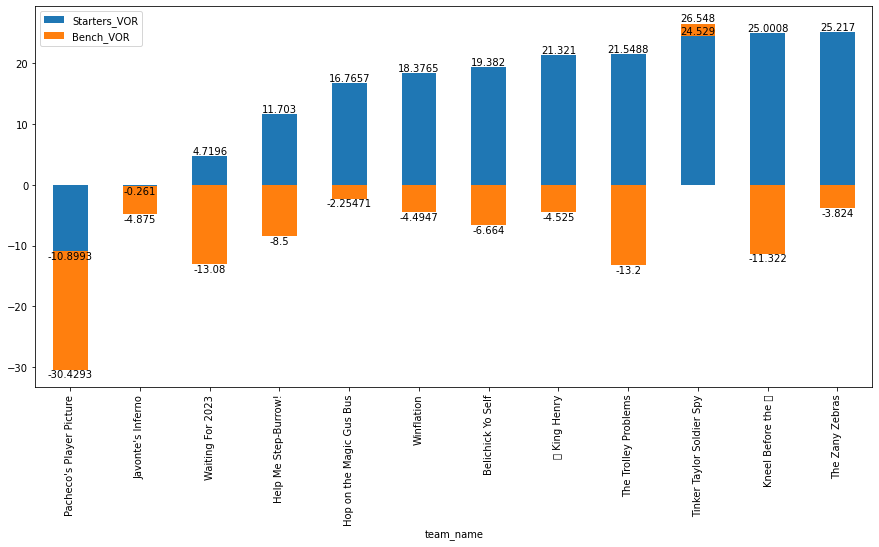

In [121]:
#  Post-draft VOR calculation
plt.rcParams['figure.figsize'] = [15, 7]
rosters_df['Starters_VOR'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Bench_VOR'] = rosters_df['bench'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Team_VOR'] = rosters_df['players'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))

ax = rosters_df.sort_values('Starters_VOR')[['Starters_VOR', 'Bench_VOR', 'team_name']].plot.bar(x='team_name', stacked=True)
for container in ax.containers:
    ax.bar_label(container)

[Text(0, 0, '-10.8993'),
 Text(0, 0, '-0.261'),
 Text(0, 0, '4.7196'),
 Text(0, 0, '11.703'),
 Text(0, 0, '16.7657'),
 Text(0, 0, '18.3765'),
 Text(0, 0, '19.382'),
 Text(0, 0, '21.321'),
 Text(0, 0, '21.5488'),
 Text(0, 0, '24.529'),
 Text(0, 0, '25.0008'),
 Text(0, 0, '25.217')]

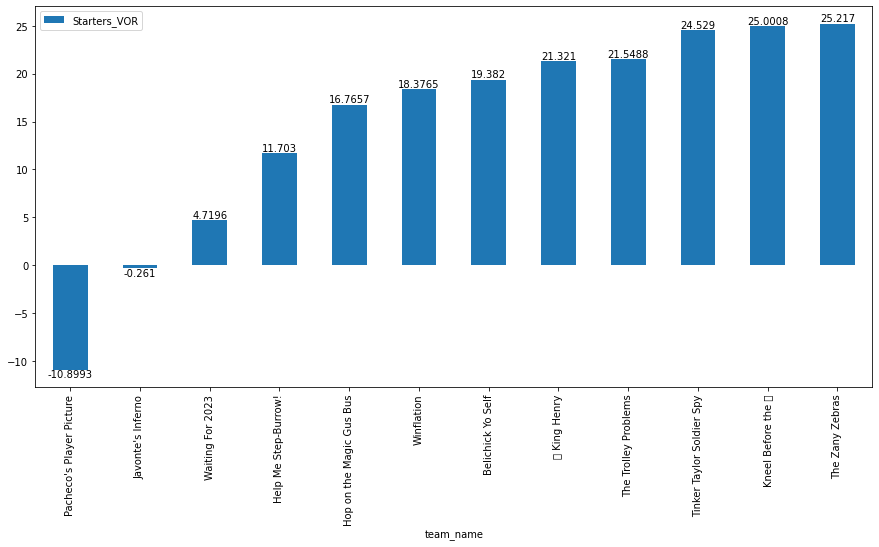

In [122]:
ax = rosters_df.sort_values('Starters_VOR').plot.bar(x='team_name', y='Starters_VOR')
ax.bar_label(ax.containers[0])


In [123]:
for col in ['Floor','Points','Ceiling','Uncertainty']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)

In [124]:
players_df.loc[[x for x in rosters_df.iloc[6]['starters'] if x != '0']].loc[:, ['full_name', 'Points', 'SD']]

,full_name,Points,SD
player_id,,,
4046,Patrick Mahomes,20.600000,1.020000
4029,Dalvin Cook,15.300000,0.356000
3969,Leonard Fournette,13.000000,0.341000
3199,Michael Thomas,9.060000,0.279000
6943,Gabe Davis,10.500000,1.900000
5906,Dawson Knox,5.430000,0.368000
4866,Saquon Barkley,14.100000,0.726000
7839,Evan McPherson,9.910000,0.663000
NO,NaN,5.620000,0.306000


[Text(0, 0, '59.42'),
 Text(0, 0, '72.87'),
 Text(0, 0, '76.95'),
 Text(0, 0, '86.1'),
 Text(0, 0, '88.77'),
 Text(0, 0, '96.47'),
 Text(0, 0, '96.58'),
 Text(0, 0, '98.38'),
 Text(0, 0, '98.63'),
 Text(0, 0, '101.71'),
 Text(0, 0, '103.28'),
 Text(0, 0, '103.52')]

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


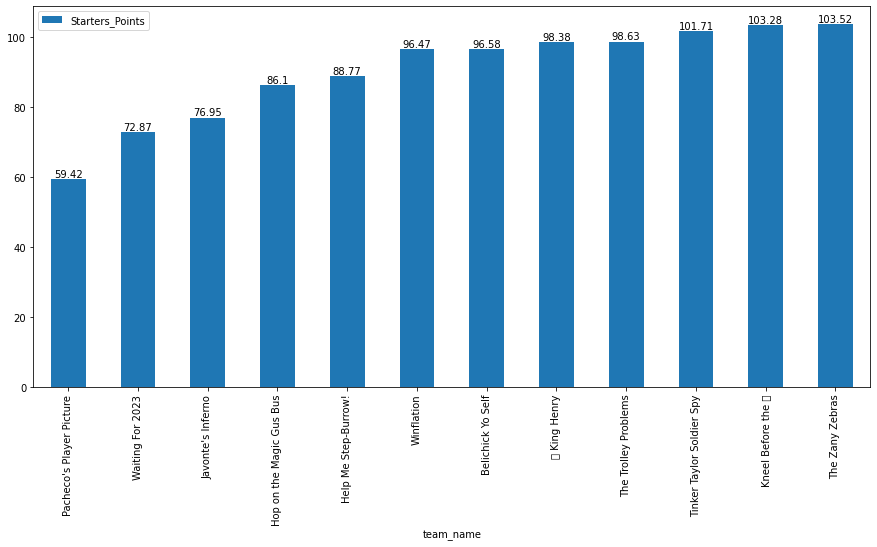

In [125]:
ax = rosters_df.sort_values('Starters_Points').plot.bar(x='team_name', y='Starters_Points')
ax.bar_label(ax.containers[0])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


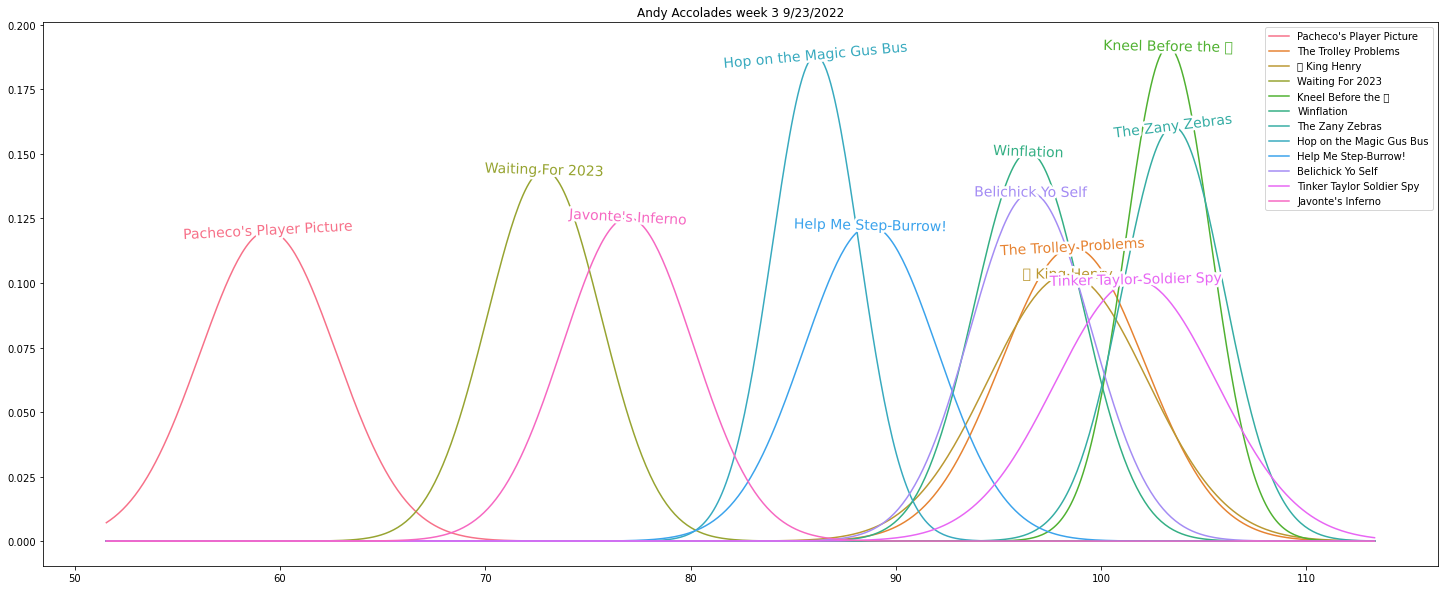

In [126]:
plt.rcParams['figure.figsize'] = [25, 10]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Points'].min() - 2*rosters_df['Starters_SD'].max(), rosters_df['Starters_Points'].max() + 2.5*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Points'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Points'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Accolades week 3 9/23/2022')
plt.show()

In [127]:
rosters_df.loc[:, ['team_name', 'Starters_Points', 'Starters_SD']].sort_values(by='Starters_Points')

,team_name,Starters_Points,Starters_SD
0,Pacheco's Player Picture,59.420000,3.318040
3,Waiting For 2023,72.870000,2.776746
11,Javonte's Inferno,76.950000,3.182853
7,Hop on the Magic Gus Bus,86.100000,2.120512
8,Help Me Step-Burrow!,88.770000,3.265789
5,Winflation,96.470000,2.646929
9,Belichick Yo Self,96.580000,2.954767
2,💩 King Henry,98.380000,3.863483
1,The Trolley Problems,98.630000,3.505137
10,Tinker Taylor Soldier Spy,101.710000,3.943552


In [128]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Ceiling')

,team_name,Starters_Ceiling,Starters_Floor
0,Pacheco's Player Picture,78.380000,49.670000
3,Waiting For 2023,88.160000,60.950000
11,Javonte's Inferno,93.560000,59.160000
7,Hop on the Magic Gus Bus,100.600000,80.230000
8,Help Me Step-Burrow!,106.240000,73.500000
5,Winflation,111.090000,86.110000
9,Belichick Yo Self,112.160000,82.480000
2,💩 King Henry,117.340000,84.860000
6,The Zany Zebras,118.710000,92.850000
1,The Trolley Problems,120.820000,88.370000


In [129]:
week = 3
matchups = league.get_matchups(week)
matchups_df = pd.DataFrame(matchups)
mu = matchups_df.groupby('matchup_id')

In [130]:
num_matchups = len(rosters_df) // 2

matchup_prob_df = pd.DataFrame()


pd.set_option('display.float_format', '{:.6f}'.format)

for i in range(1, num_matchups+1):
    p1, p2 = mu.get_group(i)['roster_id'].iloc[0] - 1, mu.get_group(i)['roster_id'].iloc[1] - 1
    d_mean = rosters_df.iloc[p1]['Starters_Points'] - rosters_df.iloc[p2]['Starters_Points']
    d_var = rosters_df.iloc[p1]['Starters_Variance'] + rosters_df.iloc[p2]['Starters_Variance']
    # victory_prob = (1 - norm(d_mean, d_var**(1/2)).cdf(0))
    victory_prob = (1 - norm(d_mean, d_var).cdf(0))
    row = {'team1': rosters_df.iloc[p1]['team_name'], 'team2': rosters_df.iloc[p2]['team_name'], 'victory_probability': victory_prob, 'd_mean': d_mean, 'd_var': d_var}
    matchup_prob_df = matchup_prob_df.append(row, ignore_index=True)

print(matchup_prob_df.loc[:, ['team1', 'team2', 'victory_probability']])

                      team1                      team2  victory_probability
0  Pacheco's Player Picture       Help Me Step-Burrow!             0.087851
1           The Zany Zebras  Tinker Taylor Soldier Spy             0.533209
2              💩 King Henry           Waiting For 2023             0.870113
3  Hop on the Magic Gus Bus          Belichick Yo Self             0.214091
4      The Trolley Problems          Javonte's Inferno             0.833264
5        Kneel Before the 👑                 Winflation             0.725837


In [131]:
players_df[players_df['Position'] == 'DST']['VOR'].sort_values()

player_id
IND   -1.610000
DET   -1.420000
JAX   -1.260000
GB    -1.020000
WAS   -0.953000
LV    -0.753000
ARI   -0.728000
BAL   -0.653000
TB    -0.635000
DEN   -0.608000
NYG   -0.603000
ATL   -0.593000
MIA   -0.463000
CIN   -0.313000
NE    -0.313000
SF    -0.300000
NYJ   -0.293000
KC    -0.273000
PIT   -0.155000
CLE   -0.143000
SEA   -0.140000
CAR   -0.003330
TEN    0.000000
LAC    0.001670
MIN    0.056700
LAR    0.061700
PHI    0.113000
NO     0.207000
CHI    0.340000
BUF    0.577000
HOU    0.727000
DAL    0.782000
Name: VOR, dtype: float64